In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pearson_util 
import descartes
import pygeoj


In [3]:
# here is a comment
df = pd.DataFrame([0, 1, 4])

In [4]:
df[0]

0    0
1    1
2    4
Name: 0, dtype: int64

# This is my data processing part
Here I do A, B, and C

<AxesSubplot:>

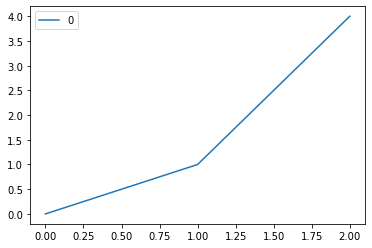

In [5]:
df.plot()

In [35]:
gdf123 = gpd.read_file('C:/Users/seanp/python/NUTS_RG_60M_2016_3035_LEVL_3.geojson')

In [7]:
gdf = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_60M_2016_3035_LEVL_3.geojson')

<AxesSubplot:>

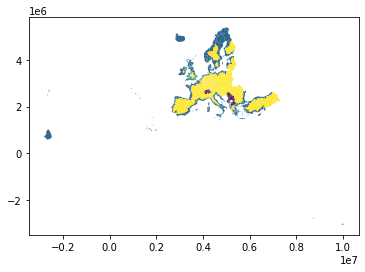

In [8]:
gdf.plot('COAST_TYPE')

In [9]:
gdf.head()

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry
0,CZ052,3,4,Královéhradecký kraj,CZ,CZ052,CZ052,Královéhradecký kraj,3,2,"POLYGON ((4752267.584 3079151.392, 4768791.122..."
1,CZ053,3,4,Pardubický kraj,CZ,CZ053,CZ053,Pardubický kraj,3,3,"POLYGON ((4812156.935 2965655.696, 4782782.205..."
2,CZ063,3,4,Kraj Vysočina,CZ,CZ063,CZ063,Kraj Vysočina,3,3,"POLYGON ((4782782.205 2960974.984, 4775981.726..."
3,CZ064,3,4,Jihomoravský kraj,CZ,CZ064,CZ064,Jihomoravský kraj,3,2,"POLYGON ((4841157.679 2932184.124, 4851727.509..."
4,CZ071,3,2,Olomoucký kraj,CZ,CZ071,CZ071,Olomoucký kraj,3,2,"POLYGON ((4849853.547 3042644.759, 4835135.745..."


# Creating dataframes of average national annual road freight transport by regions (NUTS 3) and by group of goods (1 000 t)

In [10]:
#National annual road freight transport by regions of unloading (NUTS 3) and by group of goods (1 000 t), from 2008 onwards (road_go_na_ru3g)
df_unloading = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_ru3g.tsv.gz',['subsector', 'unit', 'region'])

In [11]:
df_unloading_total = df_unloading.loc['TOTAL']

In [12]:
df_unloading_total = df_unloading_total.droplevel(0)

In [13]:
#sets index of the df to the same index the gdf has and thereby delets all rowes which have a different id (old NUTS 3 data)
df_unloading_nuts3 = df_unloading_total.reindex(gdf.set_index('id').index)

In [14]:
#filters the countries that have no data
no_data_nuts3 = df_unloading_nuts3[df_unloading_nuts3.isna().all(axis=1)].sort_index().index

In [15]:
df_unloading_nuts3.head()

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,,,,,,,,,,,,
CZ052,29969.0,24903.0,22386.0,23670.0,21968.0,16606.0,15799.0,14299.0,17991.0,13200.0,17589.0,18524.0
CZ053,27400.0,16323.0,19488.0,19740.0,18901.0,16187.0,14604.0,12494.0,14595.0,12911.0,16147.0,18915.0
CZ063,22351.0,27949.0,20844.0,21804.0,19773.0,16770.0,13575.0,11010.0,13570.0,16185.0,19154.0,20724.0
CZ064,50259.0,47715.0,43946.0,38460.0,40193.0,35845.0,29229.0,26105.0,26042.0,28307.0,31709.0,39836.0
CZ071,35445.0,33948.0,26903.0,24765.0,24243.0,24466.0,15766.0,22286.0,18700.0,18055.0,23132.0,23168.0


In [16]:
#National annual road freight transport by regions of loading (NUTS 3) and by group of goods (1 000 t), from 2008 onwards (road_go_na_rl3g
df_loading = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_rl3g.tsv.gz',['subsector', 'unit', 'region'])

In [17]:
df_loading_total = df_loading.loc['TOTAL']

In [18]:
df_loading_total = df_loading_total.droplevel(0)

In [19]:
#sets index of the df to the same index the gdf has and thereby delets all rowes which have a different id (old NUTS 3 data)
df_loading_nuts3 = df_loading_total.reindex(gdf.set_index('id').index)

In [20]:
no_data_nuts3 = df_unloading_nuts3[df_unloading_nuts3.isna().all(axis=1)].sort_index().index

In [21]:
df_loading_nuts3.head()

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,,,,,,,,,,,,
CZ052,31164.0,23410.0,22302.0,22533.0,20556.0,16265.0,15133.0,14044.0,17536.0,12320.0,16522.0,17859.0
CZ053,27127.0,20301.0,20399.0,21064.0,19896.0,16948.0,15222.0,12602.0,14166.0,14423.0,16343.0,20090.0
CZ063,22196.0,26155.0,18682.0,20785.0,19078.0,15516.0,12487.0,9854.0,13296.0,14551.0,18543.0,20061.0
CZ064,49041.0,47453.0,43448.0,38848.0,40457.0,35683.0,29350.0,25806.0,26051.0,27880.0,31335.0,40006.0
CZ071,37656.0,34631.0,29204.0,26120.0,25596.0,26760.0,18776.0,23872.0,21159.0,19474.0,25554.0,25133.0


In [22]:
#Concatinates df --> takes 2 df and joins them together
df_average_transport_total = pd.concat((df_unloading_nuts3, df_loading_nuts3))

In [23]:
#takes lines with same index and calculates mean of them
df_average_transport_total = df_average_transport_total.groupby(df_average_transport_total.index).mean()

In [24]:
#sets the index 'country' and takes it from the cntr_code column of the gdf
df_average_transport_total = df_average_transport_total.set_index(gdf.set_index('CNTR_CODE').index.rename('country'), append=True)

In [25]:
df_average_transport_total.tail()

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
UKN12,UK,2514.0,3325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN13,UK,5038.0,3286.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN14,UK,4558.0,2368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN15,UK,5073.5,3731.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN16,UK,4020.0,4223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Compacted

In [26]:
#unloading
df_unloading_GT01 = df_unloading.loc['GT01']
df_unloading_GT01 = df_unloading_GT01.droplevel(0)
df_unloading_GT01_nuts3 = df_unloading_GT01.reindex(gdf.set_index('id').index)
#loading
df_loading_GT01 = df_loading.loc['GT01']
df_loading_GT01 = df_loading_GT01.droplevel(0)
df_loading_GT01_nuts3 = df_loading_GT01.reindex(gdf.set_index('id').index)
#combining
df_average_transport_GT01 = pd.concat((df_unloading_GT01_nuts3, df_loading_GT01_nuts3))
df_average_transport_GT01 = df_average_transport_GT01.groupby(df_average_transport_GT01.index).mean()
df_average_transport_GT01 = df_average_transport_GT01.set_index(gdf.set_index('CNTR_CODE').index.rename('country'), append=True)
#share
df_transport_share_GT01 = df_average_transport_GT01.div(df_average_transport_total)
df_transport_share_GT01.tail()

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
UKN12,UK,0.132458,0.065865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN13,UK,0.035728,0.067701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN14,UK,0.032032,0.016470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN15,UK,0.149010,0.081211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN16,UK,0.098383,0.085958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#unloading
df_unloading_GT02 = df_unloading.loc['GT02']
df_unloading_GT02 = df_unloading_GT02.droplevel(0)
df_unloading_GT02_nuts3 = df_unloading_GT02.reindex(gdf.set_index('id').index)
#loading
df_loading_GT02 = df_loading.loc['GT02']
df_loading_GT02 = df_loading_GT02.droplevel(0)
df_loading_GT02_nuts3 = df_loading_GT02.reindex(gdf.set_index('id').index)
#combining
df_average_transport_GT02 = pd.concat((df_unloading_GT02_nuts3, df_loading_GT02_nuts3))
df_average_transport_GT02 = df_average_transport_GT02.groupby(df_average_transport_GT02.index).mean()
df_average_transport_GT02 = df_average_transport_GT02.set_index(gdf.set_index('CNTR_CODE').index.rename('country'), append=True)
#share
df_transport_share_GT02 = df_average_transport_GT02.div(df_average_transport_total)
df_transport_share_GT02.tail()

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
UKN12,UK,0.016508,0.006316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN13,UK,NaN,0.010650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN14,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN15,UK,0.002562,0.006433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN16,UK,0.032090,0.002842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Multiply shares of transported good types with transportdistance and amount of these good types = amount of specific good types transported for specific distance in each NUTS 3 region

In [28]:
df_transportdistance = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_dctg.tsv.gz',['subsector', 'Distance','Subsector', 'Unit', 'Country'])

In [29]:
#distance is not selected yet. 'TOT' is all distance classes
df_transportdistance = df_transportdistance.loc[('TOT', 'TOTAL', 'GT01')]
df_transportdistance = df_transportdistance.droplevel(0)
df_transportdistance

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
Country,,,,,,,,,,,,
AT,20123.0,20403.0,21207.0,20101.0,18420.0,17585.0,16393.0,17401.0,16792.0,16982.0,16158.0,16370.0
BE,15288.0,14830.0,17183.0,15166.0,22226.0,15810.0,13565.0,15258.0,12517.0,12269.0,12766.0,12279.0
BG,18391.0,16911.0,20428.0,13730.0,15953.0,15894.0,17106.0,13491.0,12620.0,11862.0,9458.0,9437.0
CH,20354.0,18403.0,18184.0,21628.0,20123.0,17602.0,19401.0,16091.0,14448.0,17053.0,14878.0,17348.0
CY,1997.0,2448.0,2290.0,1706.0,1570.0,1103.0,1530.0,2401.0,1451.0,1724.0,2016.0,1689.0
CZ,48847.0,43147.0,44013.0,43167.0,43299.0,42064.0,42518.0,38820.0,37777.0,36917.0,37724.0,42282.0
DE,160035.0,159232.0,160675.0,154649.0,163074.0,166528.0,142776.0,153366.0,153241.0,145574.0,135254.0,139583.0
DK,29243.0,28607.0,27276.0,25282.0,26735.0,24098.0,22827.0,27611.0,29493.0,23662.0,19153.0,22636.0
EE,4787.0,4034.0,4478.0,3625.0,3321.0,4194.0,3868.0,4075.0,3926.0,3906.0,3154.0,2992.0


In [30]:
#mulitply transport_share_goodstype with transportamount and can be selected by distance
df_transportdistance_share_GT01 = df_transport_share_GT01.multiply(df_transportdistance, level = 'country')
df_transportdistance_share_GT01

,,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,country,,,,,,,,,,,,
AL011,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL012,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL013,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL014,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL015,CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKN12,UK,12149.599045,7388.236692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN13,UK,3277.157602,7594.246919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN14,UK,2938.065818,1847.443834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Adding column to gdf

In [31]:
#selecting 2019 column
df_tds_GT01_2019 = df_transportdistance_share_GT01
df_tds_GT01_2019 = df_tds_GT01_2019.droplevel(1)
df_tds_GT01_2019

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
id,,,,,,,,,,,,
AL011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
UKN12,12149.599045,7388.236692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN13,3277.157602,7594.246919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKN14,2938.065818,1847.443834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
gdf1 = gdf.join(df_tds_GT01_2019)

In [33]:
for col in gdf1.columns:
    print(col)

id
COAST_TYPE
MOUNT_TYPE
NAME_LATN
CNTR_CODE
FID
NUTS_ID
NUTS_NAME
LEVL_CODE
URBN_TYPE
geometry
2019 
2018 
2017 
2016 
2015 
2014 
2013 
2012 
2011 
2010 
2009 
2008 


In [34]:
gdf['GTO1_2019'] = df_tds_GT01_2019

ValueError: Wrong number of items passed 12, placement implies 1

In [ ]:
#selecting 2019 column
df_tds_GT01_2019 = df_transportdistance_share_GT01.iloc[:, 0]
df_tds_GT01_2019 = df_tds_GT01_2019.droplevel(1)
df_tds_GT01_2019

In [ ]:
print(gdf.iloc[10:70])

# Test area

In [ ]:
#trying to use different dataset with total transport amount
df_unloading_test = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ta_ru.tsv.gz',['subsector', 'unit', 'region'])
df_unloading_test

In [ ]:
idx = pd.IndexSlice
df_unloading_test = df_unloading_test.loc[idx[:,'THS_T'], :]
df_unloading_test = df_unloading_test.droplevel('unit')
df_unloading_test

In [ ]:
df_unloading_test = df_unloading_test.reindex(gdf.set_index('id').index)




df_unloading_test = df_unloading_test.loc[idx[:,['THS_T']]]
df_unloading_test = df_unloading_test.droplevel(1)
df_unloading_total = df_unloading.loc['THS_T']
df_unloading_test

In [ ]:
df_unloading_test = df_unloading_test.droplevel(0)

In [ ]:
#sorting gdf according to id so it might aligne with eurostats data
gdf_sort = gdf.sort_values(by=['id'])

In [ ]:
#selecting 2019 column
df_at_2019 = df_average_transport.iloc[:, 0]

In [ ]:
print(df_at_2019.iloc[100:105])

In [ ]:
gdf_sort['TRANSPORT_AMOUNT_2019'] = df_at_2019

In [ ]:
print(gdf_sort.iloc[100:150])

In [ ]:
gdf_sort.head()

In [ ]:
#alinge dataframes and delet all lines with no shared id